# On Recurrent Neural Networks for Sequence-based Processing in Communications
## In this notebook we show how to build a decoder for convolutional codes based on recurrent neural networks
Accompanying code of paper ["On Recurrent Neural Networks for Sequence-based Processing in Communications" by Daniel Tandler, Sebastian Dörner, Sebastian Cammerer, Stephan ten Brink](https://arxiv.org/abs/1905.09983)

If you find this code helpful please cite this work using the following bibtex entry:

```tex
@article{RNN-Conv-Decoding-Tandler2019,
  author    = {Daniel Tandler and
               Sebastian D{\"{o}}rner and
               Sebastian Cammerer and
               Stephan ten Brink},
  title     = {On Recurrent Neural Networks for Sequence-based Processing in Communications},
  journal   = {CoRR},
  year      = {2019},
  url       = {http://arxiv.org/abs/1905.09983},
}
```

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.15.0


# Code Setup

We first set up a code class that holds all necessary parameters and provides functions to quickly generate large samples of encoded bits.

For this notebook, <b>only code examples for memory 1,2,4 and 6 are provided</b>.

To generate other convolutional codes check out the accompanying coding.py which uses [CommPy](https://github.com/veeresht/CommPy) to generate arbitray codes.

In [ ]:
class code:
    def __init__(self,m):
        self.m = m # Number of delay elements in the convolutional encoder
        self.tb_depth = 5*(self.m + 1) # Traceback depth of the decoder
        self.code_rate = 0.5
        if m == 1:
            self.d1 = 0o1
            self.d2 = 0o3
            self.impulse_response = np.array([0, 1, 1, 1])
            self.viterbi_reference = np.array([7.293792e-02,5.801720e-02,4.490250e-02,3.349593e-02,2.429049e-02,1.684274e-02,1.124068e-02,7.277303e-03,4.354604e-03,2.546695e-03,1.382015e-03,7.138968e-04])
        elif m == 2:
            self.d1 = 0o5
            self.d2 = 0o7
            self.impulse_response = np.array([1, 1, 0, 1, 1, 1])
            self.viterbi_reference = np.array([9.278817e-02,6.424232e-02,4.195904e-02,2.531590e-02,1.424276e-02,7.385386e-03,3.617080e-03,1.526589e-03,6.319029e-04,2.502278e-04,7.633503e-05,2.566724e-05])
        elif m == 4:
            self.d1 = 0o23
            self.d2 = 0o35
            self.impulse_response = np.array([1, 1, 0, 1, 0, 1, 1, 0, 1, 1])
            self.viterbi_reference = np.array([1.266374e-01,7.990744e-02,4.546113e-02,2.301058e-02,1.045569e-02,4.220632e-03,1.526512e-03,5.214676e-04,1.482288e-04,3.666830e-05,7.778123e-06,1.444509e-06])
        elif m == 6:
            self.d1 = 0o133
            self.d2 = 0o171
            self.impulse_response = np.array([1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1])
            self.viterbi_reference = np.array([1.547330e-01,8.593706e-02,3.985466e-02,1.544436e-02,5.221681e-03,1.378203e-03,3.501900e-04,8.042758e-05,1.676778e-05,2.989088e-06,3.444674e-07,np.NaN])
        else:
            print("Code not available!")
    
    def zero_pad(self,u):
        return np.reshape(np.stack([u,np.zeros_like(u)],axis=1),(-1,))
    
    def encode_sequence(self,u,terminate=False):
        if terminate:
            return np.convolve(self.zero_pad(u),self.impulse_response,mode='full')[:-1] % 2
        else:
            return np.convolve(self.zero_pad(u),self.impulse_response,mode='full')[:len(u)*2] % 2
    
    def encode_batch(self,u,terminate=False):
        x0 = self.encode_sequence(u[0],terminate)
        x = np.empty((u.shape[0],x0.shape[0]),dtype=np.int8)
        x[0] = x0
        for i in range(len(u)-1):
            x[i+1] = self.encode_sequence(u[i+1],terminate)
        return x

### Our SNR definition

In [ ]:
def ebnodb2std(ebnodb, coderate=1):
    ebno = 10**(ebnodb/10)
    return (1/np.sqrt(2*coderate*ebno)).astype(np.float32)

### Choose which Convolutional you want to use

In [ ]:
#code = code(m=1) # memory 1 rate 0.5 code with generator polynomials 0o1 and 0o3 (octal)
#code = code(m=2) # memory 2 rate 0.5 code with generator polynomials 0o5 and 0o7 (octal)
#code = code(m=4) # memory 4 rate 0.5 code with generator polynomials 0o23 and 0o35 (octal)
code = code(m=6) # memory 6 rate 0.5 code with generator polynomials 0o133 and 0o171 (octal)

## Parameters

In [5]:
model_name = "%s%sm%s_Model"  % (oct(code.d1),oct(code.d2),code.m)
saver_path = "trained_models/"+model_name

gradient_depth = code.tb_depth
additional_input = 0
decision_offset = int(len(code.impulse_response)/2)
sequence_length = 15

rnn_layers = 3
rnn_units_per_layer = 256
dense_layers = [16]

print("Code Rate:", code.code_rate)
print("RNN layers:", rnn_layers)
print("Units per layer:", rnn_units_per_layer)
print("Gradient depth:", gradient_depth)
print("ConvCode traceback length thump rule:",code.tb_depth)

Code Rate: 0.5
RNN layers: 3
Units per layer: 256
Gradient depth: 35
ConvCode traceback length thump rule: 35


## Tensorflow Graph

In [6]:
graph = tf.Graph()
with graph.as_default():
    
    # Encoded Sequence Input
    x = tf.placeholder(tf.float32,shape=[2*gradient_depth+sequence_length,None,2*(1+2*additional_input)],name="coded_sequence")
    
    # Decoding
    multi_rnn_cell = tf.contrib.cudnn_rnn.CudnnGRU(rnn_layers,rnn_units_per_layer,direction='bidirectional')
    multi_rnn_cell.build(input_shape=[2*gradient_depth+sequence_length,None,(1+2*additional_input)*2])
    
    out,(new_state,) = multi_rnn_cell(x)
    
    out_sequence = out[gradient_depth:gradient_depth+sequence_length,:,:]
    
    # final dense layers:
    for size in dense_layers:
        out_sequence = tf.layers.dense(out_sequence,size,activation=tf.nn.relu)
    u_hat = tf.layers.dense(out_sequence,1,activation=tf.nn.sigmoid)
    
    u_hat = tf.squeeze(u_hat)
    
    u_hat_bits = tf.cast(tf.greater(u_hat,0.5),tf.int8)
    
    
    # Loss function
    u_label = tf.placeholder(tf.int8,shape=[sequence_length,None],name="uncoded_bits")
    loss = tf.losses.log_loss(labels=u_label,predictions=u_hat)
    correct_predictions = tf.equal(u_hat_bits, u_label)
    ber = 1.0 - tf.reduce_mean(tf.cast(correct_predictions, tf.float32),axis=1)


    # Training
    lr = tf.placeholder(tf.float32, shape=[])
    optimizer = tf.train.RMSPropOptimizer(lr)
    step = optimizer.minimize(loss)
    
    # Init
    init = tf.global_variables_initializer()
    
    # Saver
    saver = tf.train.Saver()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating

### Let's print all trainable variables of the graph we just defined:
Note that special CudnnGRU layers generate some kind of "sub"-graph and therefore their variables are not shown here but in a so called opaque_kernel.

In [7]:
def model_summary(for_graph): #from TensorFlow slim.model_analyzer.analyze_vars source
    print("{:60}{:21}{:14}{:>17}".format('Name','Shape','Variables','Size'))
    print('{:-<112}'.format(''))
    total_size = 0
    total_bytes = 0
    for var in for_graph.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES):
        # if var.num_elements() is None or [] assume size 0.
        var_shape = var.get_shape()
        var_size = var.get_shape().num_elements() or 0
        var_bytes = var_size * var.dtype.size
        total_size += var_size
        total_bytes += var_bytes
        print("{:60}{:21}{:14}{:>11} bytes".format(var.name, str(var_shape), str(var_size), var_bytes))
    print()
    print('\033[1mTotal number of variables:\t{}\033[0m'.format(total_size))
    print('\033[1mTotal bytes of variables:\t{}\033[0m'.format(total_bytes))

model_summary(graph)

Name                                                        Shape                Variables                  Size
----------------------------------------------------------------------------------------------------------------
cudnn_gru/opaque_kernel:0                                   <unknown>            0                       0 bytes
dense/kernel:0                                              (512, 16)            8192                32768 bytes
dense/bias:0                                                (16,)                16                     64 bytes
dense_1/kernel:0                                            (16, 1)              16                     64 bytes
dense_1/bias:0                                              (1,)                 1                       4 bytes

Total number of variables:	8225
Total bytes of variables:	32900


## Generator function
Let's define a generatior function that first generates a large dataset pair of bit sequences and encoded bit sequences.

In a second step, this functions slices those datasets in shorter snippets which are then fed to the NN decoder.

In [ ]:
def generator(batch_size,iterations,gradient_depth,sequence_length,additional_input,decision_offset,sigma,apriori):
    offset = code.tb_depth + 3
    full_uncoded_sequences = np.random.randint(0,100,[batch_size,iterations+2*gradient_depth+sequence_length+offset+2*additional_input],dtype=np.int8)
    full_uncoded_sequences = np.less(full_uncoded_sequences,np.array([apriori*100],dtype=np.int8)).astype(np.int8)
    full_coded_sequences = code.encode_batch(full_uncoded_sequences)
    full_coded_sequences = np.reshape(full_coded_sequences,[batch_size,-1,int(1/code.code_rate)])
    
    # Feeding
    for i in range(iterations):
        encoded_sequences = full_coded_sequences[:,offset+i:offset+i+2*gradient_depth+sequence_length+2*additional_input,:]
        labels = full_uncoded_sequences[:,offset+i+gradient_depth+additional_input+decision_offset:offset+i+gradient_depth+additional_input+decision_offset+sequence_length]
        
        # BPSK Modulation
        modulated_sequences = (encoded_sequences.astype(np.float32) - 0.5) * 2.0

        # AWGN
        noise = np.random.normal(size=modulated_sequences.shape).astype(np.float32)
        noised_sequences = modulated_sequences + noise * sigma
        
        # Input Processing
        stack_array = []
        for k in range(2*gradient_depth+sequence_length):
            stack_array.append(noised_sequences[:,k:k+2*additional_input+1,:])
        input_x = np.stack(stack_array,axis=1)
        input_x = np.reshape(input_x,newshape=[batch_size,sequence_length+2*gradient_depth,(1+2*additional_input)*2])

        # Transpose dimensions 1 and 0 because CudnnGRU layers need [time,batch,input] feeding
        input_x = np.transpose(input_x,axes=[1,0,2])
        input_labels = np.transpose(labels,axes=[1,0])
        
        yield input_x,input_labels

## Starting a tensorflow session
We create a session for the previously defined graph and save the initial state of the graph in training_stage 0

In [9]:
sess_config = tf.ConfigProto()
#sess_config.gpu_options.per_process_gpu_memory_fraction = 0.3   # to limit the amount of GPU memory usage
sess_config.gpu_options.allow_growth = True
sess = tf.Session(graph=graph, config=sess_config)
sess.run(init)

trained_stages = 0
saver.save(sess,saver_path,global_step=trained_stages)

'trained_models/0o1330o171m6_Model-0'

## Auxiliary functions

In [ ]:
# generates a python dictionary linking numpy feeds to tensorflow tensors
def gen_feed_dict(x_feed, u_feed, lr_feed=1e-3):
    feed_dict = {
        x: x_feed,
        u_label: u_feed,
        lr: lr_feed,
    }
    return feed_dict

# runs a single batch to predict u_hat and calculate the BER
def test_step(x_feed, u_feed):
    return sess.run(ber,feed_dict=gen_feed_dict(x_feed,u_feed))

# runs a monte carlo simulation of several test steps to get meaningful BERs
def test(test_parameters, plot=False, plot_baseline=False, ber_at_time=int(sequence_length/2)):
    test_sigma = ebnodb2std(test_parameters['ebnodb'],code.code_rate)
    ber = np.zeros([len(test_parameters['ebnodb']),sequence_length])
    for i in range(len(test_sigma)):
        for x_feed,u_feed in generator(test_parameters['batch_size'],test_parameters['iterations'],gradient_depth,sequence_length,additional_input,decision_offset,test_sigma[i],0.5):
            curr_ber  = test_step(x_feed, u_feed)
            ber[i] += curr_ber
        # logging
        print("SNR:",test_parameters['ebnodb'][i])
        print("BER:",ber[i]/test_parameters['iterations'])
    ber = ber/test_parameters['iterations']
    print("Final BER:",ber)
    if (plot):
        plot_bler_vs_ebnodb(test_parameters['ebnodb'], ber[:,ber_at_time], plot_baseline)
    return ber

# runs a single training step
def train_step(x_feed,u_feed,lr_feed):
    return sess.run([step,loss,ber],feed_dict=gen_feed_dict(x_feed,u_feed,lr_feed))
    
# runs a training set according to training_params
def train(training_params):
    global trained_stages
    pl = training_params['learning']
    #early_stopping = training_params['early_stopping']
    for epoch in pl:
        # learning params
        batch_size = epoch[0]
        iterations = epoch[1]
        learning_rate = epoch[2]
        ebnodb = epoch[3]
        apriori = epoch[4]
        train_sigma = ebnodb2std(ebnodb,code.code_rate)
        # logging
        logging_interval = int(iterations/10)
        logging_it_counter = 0
        logging_interval_loss = 0.0
        logging_interval_ber = np.zeros([sequence_length])
        
        print("\nTraining Epoch - Batch Size: %d, Iterations: %d, Learning Rate: %.4f, EbNodB %.1f (std: %.3f), P_apriori %.2f" % (batch_size,iterations,learning_rate,ebnodb,train_sigma,apriori))
        # training
        for x_feed,u_feed in generator(batch_size,iterations,gradient_depth,sequence_length,additional_input,decision_offset,train_sigma,apriori):
            _,curr_loss,curr_ber = train_step(x_feed,u_feed,learning_rate)
            # logging
            logging_interval_loss += curr_loss
            logging_interval_ber += curr_ber
            logging_it_counter += 1

            if logging_it_counter%logging_interval == 0:
                #if early_stopping and previous_logging_interval_loss < logging_interval_loss:
                #    print("")

                print("      Iteration %d to %d - Avg. Loss: %.3E   Avg. BER: %.3E   Min. @ BER[%d]=%.3E" % (logging_it_counter-logging_interval,
                                                                                 logging_it_counter,
                                                                                 logging_interval_loss/logging_interval,
                                                                                 np.mean(logging_interval_ber/logging_interval),
                                                                                 np.argmin(logging_interval_ber/logging_interval),
                                                                                 np.min(logging_interval_ber/logging_interval)))
                logging_interval_loss = 0.0
                logging_interval_ber = 0.0
        
        # save weights
        trained_stages += 1
        saver.save(sess,saver_path,global_step=trained_stages)
        print("      -> saved as training stage: %s-%d" % (model_name,trained_stages))

# plots a BER curve
def plot_bler_vs_ebnodb(ebnodb, ber, baseline=False):
    image = plt.figure(figsize=(12,6))
    plt.plot(ebnodb, ber, '-o')
    if baseline:
        plt.plot(ebnodb, baseline_ber, '--')
        plt.legend(['RNN Decoder', 'Viterbi Decoder']);
    plt.yscale('log')
    plt.xlabel('EbNo (dB)', fontsize=16)
    plt.ylabel('Bit-error rate', fontsize=16)

## Training
Let's define training parameters and begin with the training.

Notice that we use so called a priori ramp-up training [1].
That is, setting the a priori probability of either ones or zeros in bit vector u to a small value and later, in subsequent training epochs, raising it up till 0.5 where ones and zeros are uniformly distributed again.

In [ ]:
train_snr_db = 1.5
training_params = {
    'learning' : [ #batch_size, iterations, learning_rate, training_ebnodb, apriori
                [100,   1000, 0.001,  train_snr_db, 0.01],
                [100,   1000, 0.001,  train_snr_db, 0.1],
                [100,   1000, 0.001,  train_snr_db, 0.2],
                [100,   1000, 0.001,  train_snr_db, 0.3],
                [100,   1000, 0.001,  train_snr_db, 0.4],
                [100,   500000, 0.0001,  train_snr_db, 0.5],
                [500,   100000,  0.0001,  train_snr_db, 0.5],
                [1000,  50000,  0.0001,  train_snr_db, 0.5],
                [2000,  50000,  0.0001,  train_snr_db, 0.5],
               ]
}

In [12]:
train(training_params)


Training Epoch - Batch Size: 100, Iterations: 1000, Learning Rate: 0.0010, EbNodB 1.5 (std: 0.841), P_apriori 0.01
      Iteration 0 to 100 - Avg. Loss: 1.748E-01   Avg. BER: 1.155E-02   Min. @ BER[7]=1.070E-02
      Iteration 100 to 200 - Avg. Loss: 4.191E-02   Avg. BER: 1.119E-02   Min. @ BER[14]=1.060E-02
      Iteration 200 to 300 - Avg. Loss: 2.376E-02   Avg. BER: 1.023E-02   Min. @ BER[3]=9.100E-03
      Iteration 300 to 400 - Avg. Loss: 1.851E-02   Avg. BER: 8.600E-03   Min. @ BER[0]=7.800E-03
      Iteration 400 to 500 - Avg. Loss: 1.285E-02   Avg. BER: 5.907E-03   Min. @ BER[5]=5.300E-03
      Iteration 500 to 600 - Avg. Loss: 1.517E-02   Avg. BER: 5.187E-03   Min. @ BER[9]=3.800E-03
      Iteration 600 to 700 - Avg. Loss: 8.233E-03   Avg. BER: 2.793E-03   Min. @ BER[5]=1.800E-03
      Iteration 700 to 800 - Avg. Loss: 3.792E-03   Avg. BER: 1.233E-03   Min. @ BER[8]=9.000E-04
      Iteration 800 to 900 - Avg. Loss: 2.435E-03   Avg. BER: 8.200E-04   Min. @ BER[6]=5.000E-04
   

KeyboardInterrupt: ignored

## Restoring already trained models
Since we used the tensorflow saver after each training epoch, we can load already trained models and then evaluate

In [ ]:
#saver.restore(sess,"%s-%d" % (saver_path,9))

## Evaluation: Monte Carlo BER simulation

In [14]:
test_parameters = {
    'batch_size' : 2000,
    'iterations' : 100,
    'ebnodb' : np.arange(0,5.6,0.5)
}
sim_ber = test(test_parameters,plot=False,plot_baseline=False)

SNR: 0.0
BER: [0.432155 0.432995 0.43358  0.43104  0.43075  0.432795 0.434515 0.43324
 0.43486  0.43431  0.434575 0.43521  0.43421  0.43513  0.43433 ]
SNR: 0.5
BER: [0.412145 0.41181  0.410865 0.411365 0.412465 0.410655 0.413165 0.41102
 0.41198  0.412295 0.412285 0.412115 0.413075 0.413455 0.41378 ]
SNR: 1.0
BER: [0.386745 0.38539  0.385955 0.38803  0.387115 0.38661  0.38669  0.38723
 0.387055 0.387875 0.3856   0.388115 0.388515 0.38835  0.38774 ]
SNR: 1.5
BER: [0.35756  0.35628  0.35481  0.354985 0.35695  0.35708  0.355935 0.35709
 0.356555 0.357455 0.3585   0.356615 0.35737  0.35926  0.35964 ]
SNR: 2.0
BER: [0.318685 0.32132  0.32081  0.32098  0.321825 0.321125 0.321735 0.3215
 0.323075 0.323915 0.322745 0.323345 0.32509  0.32549  0.32707 ]
SNR: 2.5
BER: [0.28964  0.288255 0.28867  0.28865  0.289935 0.289655 0.290085 0.29035
 0.28943  0.29282  0.2913   0.29413  0.293825 0.29522  0.29725 ]
SNR: 3.0
BER: [0.25148  0.250685 0.252055 0.25203  0.253485 0.2544   0.255385 0.254305
 0.25638

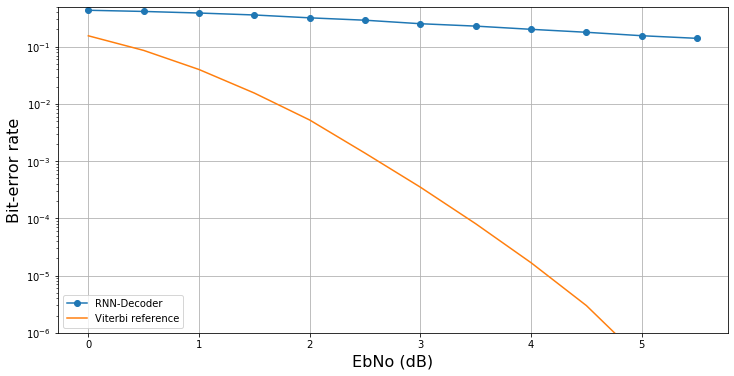

In [16]:
plot_bler_vs_ebnodb(test_parameters['ebnodb'], sim_ber[:,0])
plt.plot(np.arange(0,5.6,0.5),code.viterbi_reference)
plt.ylim(1e-6,0.5)
plt.grid()
plt.legend(['RNN-Decoder','Viterbi reference'])
plt.show();